# Collaborative Filtering project by Paige McKenzie

Includes code to perform analysis discussed in my [blog post](https://p-mckenzie.github.io/2020/03/03/collaborative-filtering/).

[Dataset](https://www.kaggle.com/azathoth42/myanimelist/version/9) available here.

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import data
shows = pd.read_csv('anime_filtered.csv', index_col='anime_id', usecols=['title', 'anime_id'])
reviews = pd.read_csv('animelists_filtered.csv', nrows=200000, usecols=['username', 'anime_id', 'my_score'])

In [3]:
# downsample to a complete set of reviews for a subset of shows
reviews = reviews[reviews['anime_id'].isin(reviews['anime_id'].unique()[:-1])]

In [4]:
# pivot for one row per user, and column per anime
reviews = pd.pivot_table(reviews, index='username', columns='anime_id', values='my_score', aggfunc=max)

reviews.head()

anime_id,21,59,74,120,178,210,232,233
username,,,,,,,,
----phoebelyn,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
--AnimeBoy--,6.0,6.0,6.0,NaN,NaN,7.0,7.0,NaN
--CyberShadow--,9.0,NaN,8.0,9.0,NaN,NaN,NaN,NaN
--FallenAngel--,9.0,8.0,NaN,NaN,NaN,8.0,NaN,NaN
--Kin--,10.0,NaN,NaN,7.0,NaN,NaN,8.0,NaN


In [5]:
# define our target shows
target_cols = [210, 232, 233]
non_targets = [col for col in reviews.columns if col not in target_cols]
target_cols

[210, 232, 233]

In [6]:
shows.loc[target_cols, 'title'].values

array(['Ranma ½', 'Cardcaptor Sakura', 'Daa! Daa! Daa!'], dtype=object)

In [7]:
# only keep users who have rated at least one target show
# also only keep users who have rated at least one other show (users we have some information about)
reviews = reviews.loc[reviews[target_cols].notna().max(axis=1) 
                      & (reviews.drop(target_cols, axis=1).notna().sum(axis=1)>0)]

In [8]:
reviews[target_cols].notna().mean()

anime_id
210    0.488617
232    0.773286
233    0.081593
dtype: float64

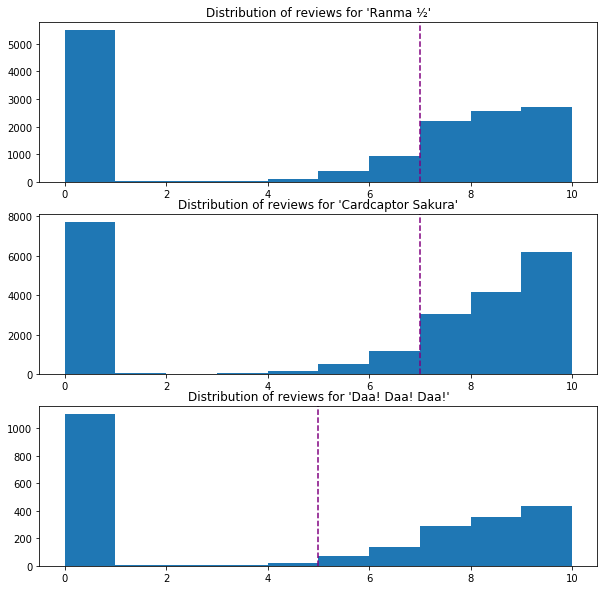

In [9]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.title("Distribution of reviews for '{}'".format(shows.loc[target_cols[0], 'title']))
plt.hist(reviews[target_cols[0]].dropna())
plt.axvline(reviews[target_cols[0]].median(), color='purple', ls='--')

pyplot.subplot(312)
plt.title("Distribution of reviews for '{}'".format(shows.loc[target_cols[1], 'title']))
plt.hist(reviews[target_cols[1]].dropna())
plt.axvline(reviews[target_cols[1]].median(), color='purple', ls='--')

pyplot.subplot(313)
plt.title("Distribution of reviews for '{}'".format(shows.loc[target_cols[2], 'title']))
plt.hist(reviews[target_cols[2]].dropna())
plt.axvline(reviews[target_cols[2]].median(), color='purple', ls='--')

#pyplot.savefig('graphs.jpg',dpi=800)
plt.show()

We can see that the majority of people who bother to rate a show do so to assert their dislike of it (hense the spike at zero). Everybody else offered a little more granularity, with most people really liking it (a score of 10) with a tail towards zero. Clearly, we would never want to recommend this show to someone who we think is going to hate it.

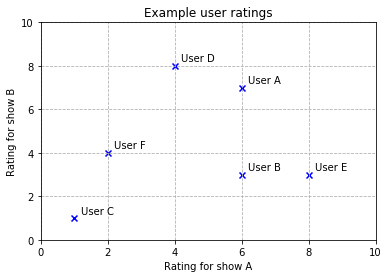

In [10]:
ratings = np.array([[6,6,1,4,8,2],
                     [7,3,1,8,3,4]]).T

labels = ['User '+chr(65+i) for i in range(ratings.shape[0])]

for (x,y),label in zip(ratings, labels):
    plt.scatter(x, y, marker='x', color='blue')
    plt.text(x+0.2, y+0.2, label, fontsize=10)
    #plt.plot([0, x], [0, y], color='grey', linestyle='--')

plt.xlim((0,10))
plt.ylim((0,10))
plt.grid(which='both', linestyle='--')
plt.title("Example user ratings")
plt.xlabel("Rating for show A")
plt.ylabel("Rating for show B")
plt.show()
#plt.savefig('demo_with_lines.jpg',dpi=800)

For this exercise, we'll split the dataset into two groups:

1. Train (the "known") - users who have scored the show we'll recommend, and whose scores we'll use to model
2. Test (the "unknown") - users who have scored the show we'll recommend, but whose scores we'll ignore and only use at the end, for measuring how well we targeted the subset that would enjoy the show

Our goal for this project is to successfully predict how an unknown user would rate a new show, given their existing watching preferences.

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(reviews, test_size=.3, random_state=1)

#del reviews

In [12]:
from sklearn.metrics import mean_absolute_error

# baseline (median)
baselines = []

for target_col in target_cols:
    score = mean_absolute_error(test[target_col].dropna(),
                    np.repeat(train[target_col].median(), test[target_col].notna().sum()))
    baselines.append(score)
    print("Error in scores when recommending '{}' (median baseline): {}".format(shows.loc[target_col, 'title'],
        round(score, 2)))

Error in scores when recommending 'Ranma ½' (median baseline): 3.47
Error in scores when recommending 'Cardcaptor Sakura' (median baseline): 3.37
Error in scores when recommending 'Daa! Daa! Daa!' (median baseline): 3.82


## Collaborative Filtering

In [13]:
train_targets = train[target_cols]
test_targets = test[target_cols]

train = train.drop(target_cols, axis=1)
test = test.drop(target_cols, axis=1)

In [14]:
# zero-center reviews, saving the average per user
train_mean = train.mean(axis=1)
test_mean = test.mean(axis=1)

train = train.apply(lambda col:col-train_mean)
test = test.apply(lambda col:col-test_mean)

train_targets = train_targets.apply(lambda col:col-train_mean)
test_targets = test_targets.apply(lambda col:col-test_mean)

In [15]:
# find inter-user similarity (ignoring our target columns)
from sklearn.metrics.pairwise import cosine_similarity

sim = pd.DataFrame(cosine_similarity(train.fillna(0), test.fillna(0)), 
                   index=train.index, columns=test.index)

In [16]:
# one row per known user, one column per unknown user
sim.shape

(20847, 8935)

In [17]:
for target_col, baseline in zip(target_cols, baselines):
    # actual ratings for first target show (for those users in the test set who rated it)
    actual = (test_targets[target_col]+test_mean).dropna()
    
    # get the most similar user's adjustment on this show, 
    ## then apply that adjustment to the unknown user's avg score
    pred_single = sim.loc[train_targets[target_col].notna(), test_targets[target_col].notna()].apply(lambda col:
                          train_targets.loc[col.idxmax(), target_col] if col.max()>0 else 0)+test_mean.reindex(actual.index)
    
    pred_multiple = sim.loc[train_targets[target_col].notna(), test_targets[target_col].notna()].apply(lambda col:
                          train_targets.loc[col.nlargest(15).index, target_col][col.nlargest(15)>0].mean()).fillna(0)+test_mean.reindex(actual.index)
    
    # adjust impossible scores
    pred_single[pred_single<0] = 0
    pred_single[pred_single>10] = 10
    pred_multiple[pred_multiple<0] = 0
    pred_multiple[pred_multiple>10] = 10

    score_single = mean_absolute_error(actual,
                                pred_single)
    score_multiple = mean_absolute_error(actual,
                                pred_multiple)
    
    print("Error in scores when recommending '{0}' (single most similar user): {1}, decreasing the baseline error by {2:.1%}".format(shows.loc[target_col, 'title'],
        round(score_single, 2),
        (baseline-score_single)/baseline))
    print("Error in scores when recommending '{0}' (25 most similar users): {1}, decreasing the baseline error by {2:.1%}".format(shows.loc[target_col, 'title'],
        round(score_multiple, 2),
        (baseline-score_multiple)/baseline))
    print()

Error in scores when recommending 'Ranma ½' (single most similar user): 3.36, decreasing the baseline error by 2.9%
Error in scores when recommending 'Ranma ½' (25 most similar users): 2.95, decreasing the baseline error by 14.9%

Error in scores when recommending 'Cardcaptor Sakura' (single most similar user): 3.13, decreasing the baseline error by 7.0%
Error in scores when recommending 'Cardcaptor Sakura' (25 most similar users): 2.82, decreasing the baseline error by 16.2%

Error in scores when recommending 'Daa! Daa! Daa!' (single most similar user): 2.83, decreasing the baseline error by 25.8%
Error in scores when recommending 'Daa! Daa! Daa!' (25 most similar users): 2.58, decreasing the baseline error by 32.5%



Sure enough, it looks like the wisdom of the herd does really well!

## The true power of Collaborative Filtering

Dataset reduction! We only need to "remember" a handful of user's preferences, rather than all of them.

In [18]:
reviews.head()

anime_id,21,59,74,120,178,210,232,233
username,,,,,,,,
--AnimeBoy--,6.0,6.0,6.0,NaN,NaN,7.0,7.0,NaN
--FallenAngel--,9.0,8.0,NaN,NaN,NaN,8.0,NaN,NaN
--Kin--,10.0,NaN,NaN,7.0,NaN,NaN,8.0,NaN
--RIE--,6.0,0.0,5.0,NaN,NaN,NaN,0.0,NaN
-0_o-,NaN,0.0,0.0,NaN,0.0,10.0,9.0,0.0


In [19]:
reviews.shape

(29782, 8)

In [20]:
prev_mem = reviews.memory_usage().sum()
print("Current memory usage: {} MB".format(round(prev_mem/(10**6), 2)))

Current memory usage: 2.14 MB


In [21]:
# hack to groupby 'na' values as well
reviews.loc[:,non_targets] = reviews.loc[:,non_targets].fillna(-1)

reviews = pd.concat([reviews.groupby(non_targets)[target_cols].mean(), reviews.groupby(non_targets).size().rename('weight')],
          axis=1).reset_index().replace(-1, np.nan)

reviews.head()

,21,59,74,120,178,210,232,233,weight
0,NaN,NaN,NaN,NaN,0.0,3.777778,5.542857,4.333333,43
1,NaN,NaN,NaN,NaN,2.0,NaN,4.500000,NaN,2
2,NaN,NaN,NaN,NaN,4.0,8.000000,6.000000,NaN,2
3,NaN,NaN,NaN,NaN,5.0,NaN,5.600000,3.500000,5
4,NaN,NaN,NaN,NaN,6.0,8.000000,7.666667,NaN,3


In [22]:
reviews.shape

(4146, 9)

In [23]:
new_mem = reviews.memory_usage().sum()
print("New memory usage: {} MB".format(round(new_mem/(10**6), 2)))

New memory usage: 0.3 MB


In [24]:
new_mem/prev_mem

0.13924891246763518